## 17​​3 - Making Theta-E Maps with RTMA Data

[Youtube](https://www.youtube.com/watch?v=Mmit14HnJ-s)

In [16]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
from siphon.catalog import TDSCatalog
import numpy as np
import metpy

In [18]:
dt = datetime(2022, 9, 10) - timedelta(days = 2)

In [19]:
rtma_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xtml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray = True)
rtma_data = rtma_data.metpy.parse_cf()
rtma_data

<xarray.Dataset>
Dimensions:                                                              (
                                                                          time12Offset: 1,
                                                                          : 2,
                                                                          reftime15: 725,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          ...
                                                                          time13Offset: 1,
                                                                          reftime12: 724,
                                                                          time10Offset: 1,
                                                                          reftime10: 724,
                                                                          time2Offset: 1,
                                                                          altitude_above_msl: 1)
Coordinates: (12/54)
  * time12Offset                                                         (time12Offset) float64 ...
  * reftime15                                                            (reftime15) datetime64[ns] ...
    time12                                                               (reftime15, time12Offset) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * reftime4                                                             (reftime4) datetime64[ns] ...
    ...                                                                   ...
  * time10Offset                                                         (time10Offset) float64 ...
    time10                                                               (reftime12, time10Offset) datetime64[ns] ...
  * reftime10                                                            (reftime10) datetime64[ns] ...
  * time2Offset                                                          (time2Offset) float64 ...
    time2                                                                (reftime10, time2Offset) datetime64[ns] ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
Dimensions without coordinates: 
Data variables: (12/23)
    LambertConformal_Projection                                          int32 ...
    time12Offset_bounds                                                  (time12Offset, ) datetime64[ns] ...
    time12_bounds                                                        (reftime15, time12Offset, ) datetime64[ns] ...
    Total_cloud_cover_Analysis_entire_atmosphere_single_layer            (reftime4, time6Offset, y, x) float32 ...
    Pressure_error_surface                                               (reftime5, time15Offset, y, x) float32 ...
    Wind_direction_from_which_blowing_error_height_above_ground          (reftime13, time9Offset, height_above_ground, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_Analysis_height_above_ground                              (reftime, time4Offset, height_above_ground, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (reftime12, time10Offset, height_above_ground, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (reftime10, time2Offset, height_above_ground, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (reftime14, time14Offset, y, x) float32 ...
    Dewpoint_temperature_Analysis_height_above_ground                    (reftime9, time13Offset, height_above_ground1, y, x) float32 ...
    Total_precipitation_Forec

In [32]:
pres = rtma_data['Pressure_Analysis_surface'].metpy.sel(reftime1 = dt, method = 'nearest').squeeze()
temp = rtma_data['Temperature_Analysis_height_above_ground'].metpy.sel(reftime11 = dt, method = 'nearest').squeeze()
dewp = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].metpy.sel(reftime9 = dt, method = 'nearest').squeeze()

In [33]:
temp

<xarray.DataArray 'Temperature_Analysis_height_above_ground' (y: 1377, x: 2145)>
[2953665 values with dtype=float32]
Coordinates:
  * x                     (x) float32 -2.763e+06 -2.761e+06 ... 2.682e+06
  * y                     (y) float32 -2.638e+05 -2.612e+05 ... 3.231e+06
    metpy_crs             object Projection: lambert_conformal_conic
    height_above_ground1  float32 2.0
    reftime11             datetime64[ns] 2022-09-08
    time8Offset           float64 0.0
    time8                 datetime64[ns] 2022-09-08
Attributes:
    long_name:                       Temperature Analysis @ Specified height ...
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LambertConformal_Projection
    Grib_Variable_Id:                VAR_7-4--1-0_L103
    Grib2_Parameter:                 [0 0 0]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                103
    Grib2_Level_Desc:                Specified height level above ground
    Grib2_Generating_Process_Type:   Analysis
    Grib2_Statistical_Process_Type:  UnknownStatType--1

In [34]:
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)
theta_e = mpcalc.smooth_gaussian(theta_e, n = 8)

In [35]:
plot_proj = theta_e.metpy.cartopy_crs

Text(0.5, 1.0, '2022-09-08 00Z')

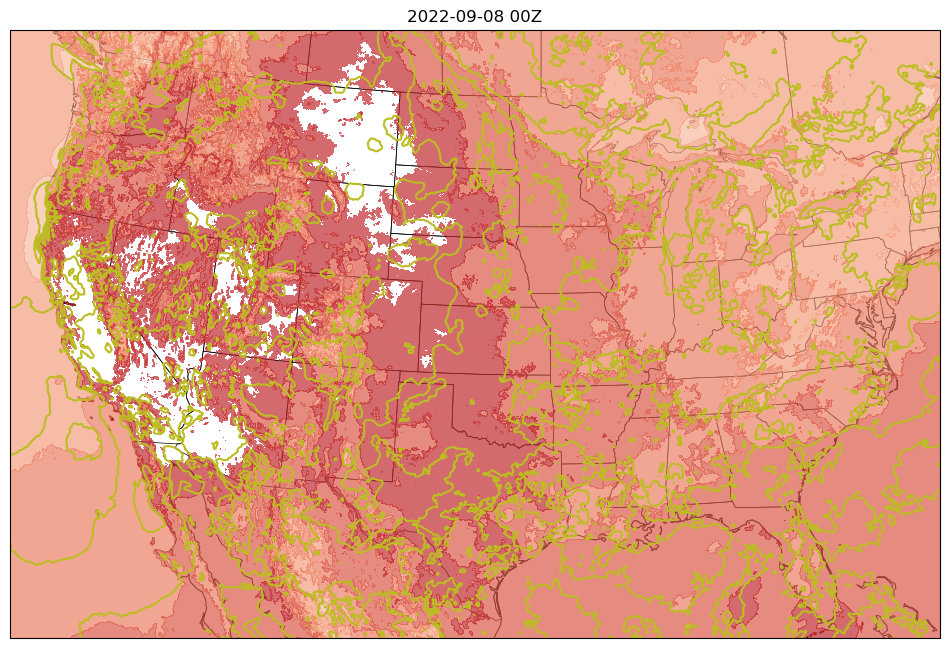

In [46]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1, projection = plot_proj)
ax.set_extent((-122, -75, 25, 50), crs = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

ax.contourf(temp.metpy.x, temp.metpy.y, temp - 273.15, transform = temp.metpy.cartopy_crs, levels = np.arange(-30, 40, 5), cmap = 'coolwarm', alpha = 0.7)
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform = theta_e.metpy.cartopy_crs, levels = np.arange(240, 400, 10), colors = 'tab:olive')
plt.title(dt.strftime('%Y-%m-%d %HZ'))